Домашнее задание №1 по курсу "Рекомендательные системы на практике"

Пирогов Владимир

Так как работал в гугл колабе, поэтому данные выкачиваю со своего гугл диска.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
from datetime import datetime

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path = '/content/drive/My Drive/CSC/req_sys/HW_1/'

Загружаем данные в блокнот в переменную data, типа DataFrame. Приводим все даты в нормальный вид и проверяем всё ли хорошо. Длтя того, чтобы дальше спокойно работать - проверим даты за которые предоставлен набор данных. 

In [3]:
data = pd.read_csv(path+'data.csv', usecols = ['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id', 'impressions', 'clicks'])

In [5]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [7]:
data["day"] = data['date_time'].dt.day

In [8]:
data["month"] = data['date_time'].dt.month

In [9]:
data.head(3) #Всё ли хорошо

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks,day,month
0,2021-09-27 00:01:30,0,0,0,0,0,1,1,27,9
1,2021-09-26 22:54:49,1,1,0,0,1,1,1,26,9
2,2021-09-26 23:57:20,2,2,3,0,0,1,1,26,9


In [14]:
data.groupby('month')['day'].value_counts()

month  day
9      26     3102610
       29     2420588
       27     2367303
       28     2307355
       30     1851189
       1            1
10     2      2128978
       1      1643448
Name: day, dtype: int64

Ой. Интересно получилось, но у нас есть элементы собранные 1-ого сентября. Для анализа они нам не нужны, так как расположены далеко по времени. Поэтому выкинем их. 


In [27]:
data.drop(data[(data['month']==9) & (data['day']==1)].index, inplace=True, axis=0)

In [28]:
data.shape

(15821471, 10)

Как видим объём данных очень большой. Далее были попытки запустить sns.pairplot. Однако они не увенчались успехов в связи с огромным объёмом данных. 

К сожалению колаб упал на этом. Видимо объём датасета очень большой. 

Перейдем к осмыслению набора данных. Заметим следующее: 
1. Логично использовать фичу  zone*impressions. Так как логично предположить что показ рекламы зависит от места расположению рекламы
2. Также интересно рассмотреть фичу отвечающую произведению страна - баннер
3. И инетерсено рассмотреть произведение регион - общее количество показов данной рекламы. 

Так как память у колаба маленькая сделаем финт ушами. Викинем самые безсмысленные значения. (зоны стран, которые встречаются менбше 100 раз, например)

К сожалению, все наши колонки имеют в основном только id соотвествующих объектов. А умножать id смысла мало - придётся делать one hot encoding.

In [64]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss
from tqdm import tqdm # для красоты
from sklearn.linear_model import LogisticRegression

Нам понадобятся три выборки - обучающая (далее train), тестовая (test) и валидационная для подбора метапараметров (val)

In [32]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data.drop(['clicks', 'date_time'], axis=1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

Выделяем тренировочные данные (исключаем последний день)

In [54]:
train = data[~(data['month']==10)]

In [55]:
X_train = train.drop(['clicks', 'date_time'], axis=1)
X_train = enc.transform(X_train)
y_train = train['clicks']

Выделяем валидационные данные

In [56]:
val = data[(data['day']==1) & (data['month']==10)]

In [58]:
X_val = train.drop(['clicks', 'date_time'], axis=1)
X_val = enc.transform(X_val)
y_val = train['clicks']

Выделяем тестовые данные

In [59]:
test = data[(data['day']==2) & (data['month']==10)]

In [60]:
X_test = test.drop(['clicks', 'date_time'], axis=1)
X_test = enc.transform(X_test)
y_test = test['clicks']

На этом подготовка данных завершена. Приступим к построению модели. И отбору лучшей из них. Так как вычислительных мощностей мало выбор будет осуществляьбся из трёх параметров. Если лучшее значение будет крайним. Попытаемся пойти в ту сторону

In [66]:
log_los = []
regularization = [0.1, 1, 10]

for c in tqdm(regularization):
  model = LogisticRegression(fit_intercept=False, C=c, solver='liblinear').fit(X_train, y_train)
  log_los.append(log_loss(y_val, model.predict_proba(X_val)))

100%|██████████| 3/3 [19:59<00:00, 399.94s/it]


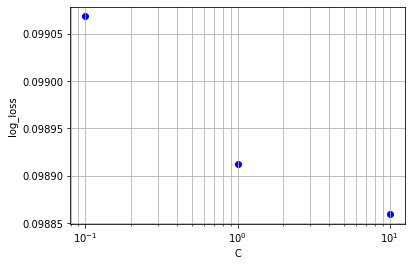

In [83]:
fig = plt.figure()
ax = plt.axes()
ax.set_xscale('log')
ax.grid(which = 'both')

plt.scatter(regularization, log_los, c="b")
plt.xlabel("C")
plt.ylabel("log_loss")
plt.show()

Как видно результаты улучшаются при уменьшении C. Однако не существенно. Поэтому остановимся на значении 10. 

Выполним последнее задание: "Свою итоговую модель примените к последнему дню датасета и вычислите log-loss. Это будет неким ответом к домашней работе."


In [85]:
model = LogisticRegression(fit_intercept=False, C=10, solver='liblinear').fit(X_train, y_train)

In [86]:
print("Log-loss:", log_loss(y_test, model.predict_proba(X_test)))

Log-loss: 0.35092550382987336
